## Q66-69. HOG特徴量の描画

In [2]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

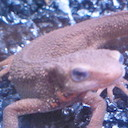

In [7]:
origin_image = cv2.cvtColor(cv2.imread('dataset/imori.jpg'), cv2.COLOR_BGR2RGB)

display(Image.fromarray(origin_image))

### グレー化+輝度勾配

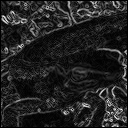

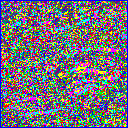

In [48]:
# グレー化
gray_image = cv2.cvtColor(origin_image.astype(np.float32), cv2.COLOR_RGB2GRAY)

# 差分を取る(微分)
gx = gray_image[1:-1, 2:] - gray_image[1:-1, :-2]
gx = np.pad(gx, pad_width=1, mode='constant', constant_values=0)
gy = gray_image[2:, 1:-1] - gray_image[:-2, 1:-1]
gy = np.pad(gy, pad_width=1, mode='constant', constant_values=0)

# 勾配強度と角度を算出
mag = np.sqrt(gx**2 + gy**2)
# mag = ((mag - mag.min()) / (mag.max() - mag.min()) * 255).astype(np.uint8)
_mag = (mag / mag.max() * 255).astype(np.uint8)
ang = np.rad2deg(np.arctan2(gy, gx))
ang[ang<0] += 180

# ９分割(20度)毎に量子化を行う
quantization = np.zeros(ang.shape, dtype=np.int32)
delta = 20.0
for i in range(9):
    quantization[(ang >= i*delta) & (ang < (i+1)*delta)] = i

colors = np.array([[0, 0, 255], [0, 255, 0], [255, 0, 0], [0, 255, 255], [255, 0, 255], [255, 255, 0],
            [0, 127, 127], [127, 0, 127], [127, 127, 0]])

rgb_image = (colors[quantization]).astype(np.uint8)

display(Image.fromarray(_mag))
display(Image.fromarray(rgb_image))

### 勾配ヒストグラム

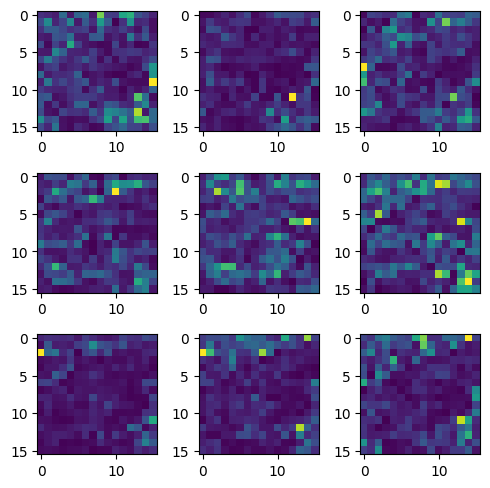

In [66]:
H, W = gray_image.shape

# 一つのセルを8ピクセルとする
N = 8
hog_feature = np.zeros((H//N, W//N, 9))

for i in range(hog_feature.shape[0]):
    for j in range(hog_feature.shape[1]):
        y0 = i*N
        x0 = j*N
        q_block = quantization[y0:y0+N, x0:x0+N]
        m_block = mag[y0:y0+N, x0:x0+N]
        for k in range(9):
            hog_feature[i, j, k] = m_block[q_block==k].sum()
# # get shape
# H, W = gray_image.shape
# N=8

# # get cell num
# cell_N_H = H // N
# cell_N_W = W // N
# hog_feature = np.zeros((cell_N_H, cell_N_W, 9), dtype=np.float32)

# # each pixel
# for y in range(cell_N_H):
#     for x in range(cell_N_W):
#         for j in range(N):
#             for i in range(N):
#                 hog_feature[y, x, quantization[y * 4 + j, x * 4 + i]] += mag[y * 4 + j, x * 4 + i]

plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(hog_feature[..., i])
plt.tight_layout()
plt.show()

### ヒストグラム正規化

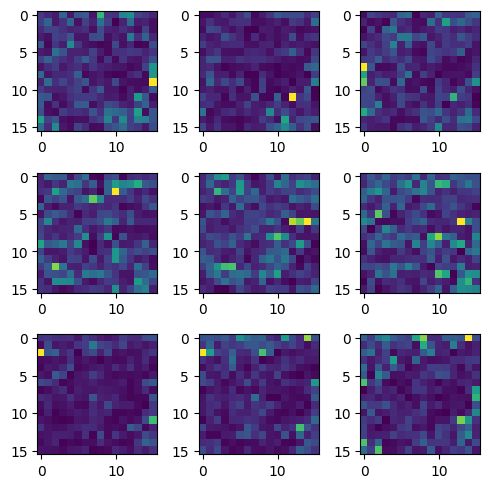

In [67]:
C = 3
CH, CW, N = hog_feature.shape
norm_histgram = hog_feature.copy()
epsilon = 1

for i in range(CH):
    for j in range(CW):
        norm_histgram[i,j] = hog_feature[i,j] / np.sqrt(np.sum(hog_feature[max(i-1,0):min(i+2,CH), max(j-1,0):min(j+2,CW)])+epsilon)

plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(norm_histgram[..., i])
plt.tight_layout()
plt.show()


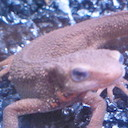

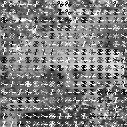

In [69]:
# draw HOG
def draw_HOG(img, histogram):
    # Grayscale
    def BGR2GRAY(img):
        gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
        return gray

    def draw(gray, histogram, N=8):
        # get shape
        H, W = gray.shape
        cell_N_H, cell_N_W, _ = histogram.shape
        
        ## Draw
        out = gray[1 : H + 1, 1 : W + 1].copy().astype(np.uint8)

        for y in range(cell_N_H):
            for x in range(cell_N_W):
                cx = x * N + N // 2
                cy = y * N + N // 2
                x1 = cx + N // 2 - 1
                y1 = cy
                x2 = cx - N // 2 + 1
                y2 = cy
                
                h = histogram[y, x] / np.sum(histogram[y, x])
                h /= h.max()
        
                for c in range(9):
                    #angle = (20 * c + 10 - 90) / 180. * np.pi
                    # get angle
                    angle = (20 * c + 10) / 180. * np.pi
                    rx = int(np.sin(angle) * (x1 - cx) + np.cos(angle) * (y1 - cy) + cx)
                    ry = int(np.cos(angle) * (x1 - cx) - np.cos(angle) * (y1 - cy) + cy)
                    lx = int(np.sin(angle) * (x2 - cx) + np.cos(angle) * (y2 - cy) + cx)
                    ly = int(np.cos(angle) * (x2 - cx) - np.cos(angle) * (y2 - cy) + cy)

                    # color is HOG value
                    c = int(255. * h[c])

                    # draw line
                    cv2.line(out, (lx, ly), (rx, ry), (c, c, c), thickness=1)

        return out

    # get gray
    gray = BGR2GRAY(img)

    # draw HOG
    out = draw(gray, histogram)

    return out

out = draw_HOG(origin_image, norm_histgram)
display(Image.fromarray(origin_image))
display(Image.fromarray(out))

(16, 16, 9)
(16, 16, 9)


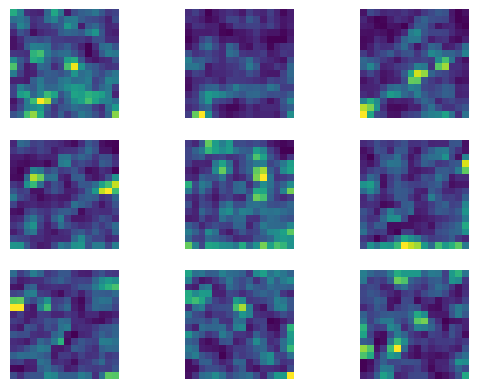

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# get HOG
def HOG(img):
    # Grayscale
    def BGR2GRAY(img):
        gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
        return gray

    # Magnitude and gradient
    def get_gradXY(gray):
        H, W = gray.shape

        # padding before grad
        gray = np.pad(gray, (1, 1), 'edge')

        # get grad x
        gx = gray[1:H+1, 2:] - gray[1:H+1, :W]
        # get grad y
        gy = gray[2:, 1:W+1] - gray[:H, 1:W+1]
        # replace 0 with 
        gx[gx == 0] = 1e-6

        return gx, gy

    # get magnitude and gradient
    def get_MagGrad(gx, gy):
        # get gradient maginitude
        magnitude = np.sqrt(gx ** 2 + gy ** 2)

        # get gradient angle
        gradient = np.arctan(gy / gx)

        gradient[gradient < 0] = np.pi / 2 + gradient[gradient < 0] + np.pi / 2

        return magnitude, gradient

    # Gradient histogram
    def quantization(gradient):
        # prepare quantization table
        gradient_quantized = np.zeros_like(gradient, dtype=np.int16)

        # quantization base
        d = np.pi / 9

        # quantization
        for i in range(9):
            gradient_quantized[np.where((gradient >= d * i) & (gradient <= d * (i + 1)))] = i

        return gradient_quantized


    # get gradient histogram
    def gradient_histogram(gradient_quantized, magnitude, N=8):
        # get shape
        H, W = magnitude.shape

        # get cell num
        cell_N_H = H // N
        cell_N_W = W // N
        histogram = np.zeros((cell_N_H, cell_N_W, 9), dtype=np.float32)

        # each pixel
        for y in range(cell_N_H):
            for x in range(cell_N_W):
                for j in range(N):
                    for i in range(N):
                        histogram[y, x, gradient_quantized[y * 4 + j, x * 4 + i]] += magnitude[y * 4 + j, x * 4 + i]

        return histogram

		# histogram normalization
    def normalization(histogram, C=3, epsilon=1):
        cell_N_H, cell_N_W, _ = histogram.shape
        ## each histogram
        for y in range(cell_N_H):
    	    for x in range(cell_N_W):
       	    #for i in range(9):
                histogram[y, x] /= np.sqrt(np.sum(histogram[max(y - 1, 0) : min(y + 2, cell_N_H),
                                                            max(x - 1, 0) : min(x + 2, cell_N_W)] ** 2) + epsilon)

        return histogram

    # 1. BGR -> Gray
    gray = BGR2GRAY(img)

    # 1. Gray -> Gradient x and y
    gx, gy = get_gradXY(gray)

    # 2. get gradient magnitude and angle
    magnitude, gradient = get_MagGrad(gx, gy)

    # 3. Quantization
    gradient_quantized = quantization(gradient)

    # 4. Gradient histogram
    histogram = gradient_histogram(gradient_quantized, magnitude)
    # print(histogram.shape)
    
    # 5. Histogram normalization
    histogram = normalization(histogram)
    # print(histogram.shape)

    return histogram


# Read image
img = cv2.imread("./dataset/imori.jpg").astype(np.float32)

# get HOG
histogram = HOG(img)
                
# Write result to file
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(histogram[..., i])
    plt.axis('off')
    plt.xticks(color="None")
    plt.yticks(color="None")
plt.show()

        
